# Course on Data Science and Geosciences, 2019
# Deep learning lecture
Pierre-Henri Conze, François Rousseau, IMT Atlantique

## Objective of this lab session: perform classification on MNIST dataset using convolutional neural networks

In lab session 3, MNIST classification has been performed relying on multi-layer perceptron (MLP). The obtained accuracy was 92% with a simple softmax regressor and 98% with MLP which can be further improved! Let us jump from this simple model to something moderately more sophisticated, namely convolutional neural networks.

For recall, MNIST is a computer vision dataset which consists of handwritten digit images with associated label. Each image in MNIST has a corresponding label, a number between 0 and 9 representing the digit drawn in the image.

### Part 1 - Data management and visualization

First, let us download and read the MNIST data.

In [2]:
import keras
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [3]:
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_test[0,:,:].shape, 'image size')

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)
60000 train samples
10000 test samples
(28, 28) image size


The MNIST data is split into two parts: 60000 data points of training data, 10000 points of test data. Each image is 28 pixels by 28 pixels. 
Let us visualize some of the data.

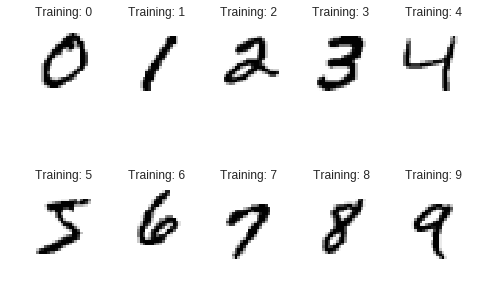

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_train == i)[0][0]
    plt.imshow(x_train[index,:,:],cmap=plt.cm.gray_r)
    plt.title('Training: %i' % y_train[index])
plt.show()

For further processing using keras functions, MNIST data must stacked in a 4D tensor with shape (samples, rows, cols, channels). In our case, channels=1 since we are working with greyscale images. As in lab session 3, pixel intensities need to rescaled between 0 and 1. Moreovre, labels can be described as one-hot vectors using the to_categorical() keras function.

In [0]:
img_rows, img_cols = 28, 28
num_classes = 10
# build 4D tensors
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# data normalization
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
# convert class vectors to binary class matrices
z_train = keras.utils.to_categorical(y_train, num_classes)
z_test = keras.utils.to_categorical(y_test, num_classes)

### Part 2 - Building a convolutional neural network with keras

The sequential Keras model is a linear stack of layers. You can create a sequential model by passing a list of layer instances to the constructor. Among the layer instances, you can use:
  - convolutional layer using Conv2D (https://keras.io/layers/convolutional/#conv2d)
  - max-pooling layer using MaxPooling2D (https://keras.io/layers/pooling/#maxpooling2d)
  - Dropout (https://keras.io/layers/core/#dropout)
  - regular densely-connected layer using Dense (https://keras.io/layers/core/#dense)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Once keras modules have been imported, we can simply add layers using the .add() method.

In addition, the model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape:

In [0]:
input_shape = (img_rows, img_cols, 1)

#### 1) Create a convolutional neural network following the architecture given below:
 - convolutional layer using 32 3x3 filters with stride 1 and "ReLU" activation
 - convolutional layer using 64 3x3 filters with stride 1 and "ReLU" activation
 - max pooling with vertical, horizontal downscale of 2
 - flatten layer (https://keras.io/layers/core/#flatten) to flatten the input array
 - dense layer with 128 units
 - dense layer with "num_classes=10" units

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Before training a model, you need to configure the learning process, which is done through the compile() method. It receives three arguments:

 - an optimizer: this could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class.
 - A loss function: this is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or an objective function.
 - A list of metrics to evaluate results. A metric could be the string identifier of an existing metric or a custom metric function.

#### 2) Define the loss, the optimizer and the metrics. Then, compile your model. You can find some help from https://keras.io/models/sequential/#compile. 

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#### 3) Describe input/output sizes of each layer. Confirm your analysis by using model.summary()

In [10]:
#from keras.utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                92170     
Total params: 110,986
Trainable params: 110,986
Non-trainable params: 0
_________________________________________________________________


#### 4) Keras models are trained on Numpy arrays of input data and labels. For training a model, we can use the fit() function (https://keras.io/models/sequential/#fit). Run the training using a batch size of 128 and 12 epochs. Test data will be used as validatation data.

In [11]:
batch_size = 128
epochs = 12
hist = model.fit(x_train, z_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_data=(x_test, z_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 11s 177us/step - loss: 0.2144 - acc: 0.9348 - val_loss: 0.0782 - val_acc: 0.9764
Epoch 2/12
60000/60000 [==============================] - 7s 116us/step - loss: 0.0632 - acc: 0.9808 - val_loss: 0.0557 - val_acc: 0.9826
Epoch 3/12
60000/60000 [==============================] - 7s 116us/step - loss: 0.0473 - acc: 0.9859 - val_loss: 0.0388 - val_acc: 0.9867
Epoch 4/12
60000/60000 [==============================] - 7s 116us/step - loss: 0.0380 - acc: 0.9890 - val_loss: 0.0352 - val_acc: 0.9888
Epoch 5/12
60000/60000 [==============================] - 7s 116us/step - loss: 0.0313 - acc: 0.9904 - val_loss: 0.0386 - val_acc: 0.9872
Epoch 6/12
60000/60000 [==============================] - 7s 116us/step - loss: 0.0265 - acc: 0.9919 - val_loss: 0.0321 - val_acc: 0.9898
Epoch 7/12
60000/60000 [==============================] - 7s 116us/step - loss: 0.0224 - acc: 0.9936 - val_loss: 0.0432 -

### Part 3 - Evaluation

The model.fit() method returns an History callback, which has a history attribute containing the lists of successive losses and other metrics.

#### 5) Display the loss and the accuracy across training 

------------------------------
Displaying losses...


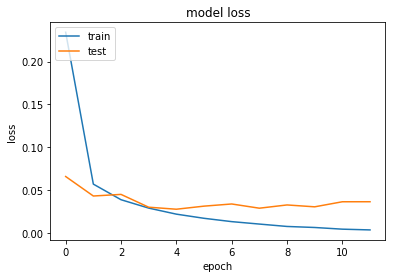

In [0]:
print('-'*30+'\n'+'Displaying losses...')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

------------------------------
Displaying losses...


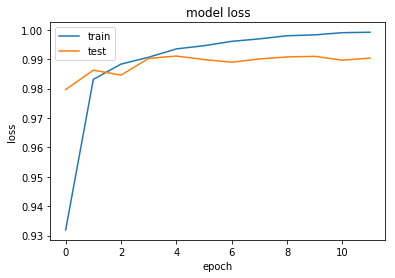

In [0]:
print('-'*30+'\n'+'Displaying losses...')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 6) Evaluate the global test loss and accuracy using the evaluate() method (https://keras.io/models/sequential/#evaluate).

In [0]:
score = model.evaluate(x_test, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0365077620536
Test accuracy: 0.9904


#### 7) Visualize some wrongly predicted data

predicted probabilities for first test sample [  5.12141361e-15   4.00329206e-12   2.74146799e-11   8.95579583e-11
   1.01383974e-14   2.70459759e-15   3.18380652e-22   1.00000000e+00
   2.40460971e-12   4.62353905e-11]
predicted label for first test sample 7
10 first wrong prediction indexes [ 18 158 321 340 359 445 449 582 583 659]


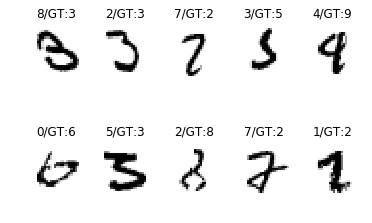

In [0]:
res = model.predict(x_test, batch_size=batch_size)
print('predicted probabilities for first test sample',res[0])
y_pred = np.argmax(res,axis=1)
print('predicted label for first test sample',y_pred[0])
indexes = np.where(y_test-y_pred != 0)[0][:10] 
print('10 first wrong prediction indexes',indexes)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_test[indexes[i],:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i/GT:%i' %(y_pred[indexes[i]],y_test[indexes[i]]))
plt.show()

Up to now, we have learned how to quickly and easily build, train, and evaluate a convolutional neural network using Keras. The final test set accuracy on MNIST dataset is approximately 99% which is better than the results obtained with MLP.

### Part 4 - Robustness to noise

#### 8) Evaluate the network predictions on noisy data with two different noise factors

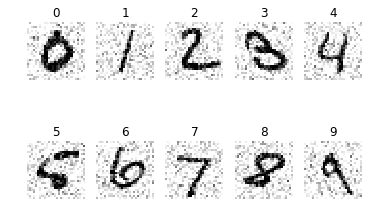

('Test loss:', 0.057375907105466466)
('Test accuracy:', 0.98280000000000001)


In [0]:
noise_factor = 0.2
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_test == i)[0][0]
    plt.imshow(x_test_noisy[index,:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i' % y_test[index])
plt.show()
score = model.evaluate(x_test_noisy, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


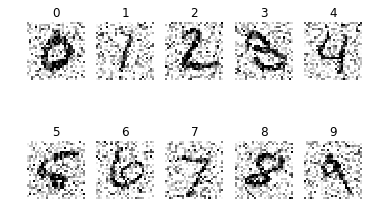

('Test loss:', 0.75176674218177797)
('Test accuracy:', 0.80659999999999998)


In [0]:
noise_factor = 0.4
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_test == i)[0][0]
    plt.imshow(x_test_noisy[index,:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i' % y_test[index])
plt.show()
score = model.evaluate(x_test_noisy, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



With strong noise, the accuracy decreases from 99% to 80% since training samples are not enough representative. Let us train the model directly on noisy data samples to see the performance.

#### 9) Train and evaluate the same CNN architecture on noisy data with 0.4 as noise factor. 

In [0]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

model_noise = Sequential()
model_noise.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_noise.add(Conv2D(64, (3, 3), activation='relu'))
model_noise.add(MaxPooling2D(pool_size=(2, 2)))
model_noise.add(Flatten())
model_noise.add(Dense(128, activation='relu'))
model_noise.add(Dense(num_classes, activation='softmax'))

model_noise.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model_noise.fit(x_train_noisy, z_train, batch_size=batch_size, epochs=epochs, verbose=1,
                validation_data=(x_test_noisy, z_test))

score = model_noise.evaluate(x_test_noisy, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 182s - loss: 0.3972 - acc: 0.8757 - val_loss: 0.1415 - val_acc: 0.9555

#### 10) What is the expected result when using Dropout layers? Evaluate the network without Dropout layers and conclude based on global test accuracy 

Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

In [0]:
model_noise2 = Sequential()
model_noise2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_noise2.add(Conv2D(64, (3, 3), activation='relu'))
model_noise2.add(MaxPooling2D(pool_size=(2, 2)))
model_noise2.add(Dropout(0.25))
model_noise2.add(Flatten())
model_noise2.add(Dense(128, activation='relu'))
model_noise2.add(Dropout(0.5))
model_noise2.add(Dense(num_classes, activation='softmax'))

model_noise2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model_noise2.fit(x_train_noisy, z_train, batch_size=batch_size, epochs=epochs, verbose=1,
                validation_data=(x_test_noisy, z_test))

score = model_noise2.evaluate(x_test_noisy, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 183s - loss: 0.5347 - acc: 0.8291 - val_loss: 0.1564 - val_acc: 0.9513

For this small convolutional network, performance is actually nearly identical with and without dropout. Here, when training and predict on noisy data, we jump from 97,8% (without dropout) to 98,0% (with dropout). Dropout is often very effective at reducing overfitting, but it is most useful when training very large neural networks.

### Part 5 - Towards deeper networks

In this last part, we come back to the original dataset, i.e. without additional noise.

#### 11) Implement a deeper convolutional neural network by adding two convolutional  layers and one max pooling layer before the first Dropout. What is the performance gain?

In [0]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.Adadelta(),
               metrics=['accuracy'])

plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model2.png')

model2.fit(x_train, z_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, z_test))

score = model2.evaluate(x_test, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 265s - loss: 0.3887 - acc: 0.8754 - val_loss: 0.0792 - val_acc: 0.9741

This slightly more deeper network reaches around 99,35% in terms of accuracy (instead of 99% as in question 6). 

#### 12) Study the confusion matrix:

Normalized confusion matrix


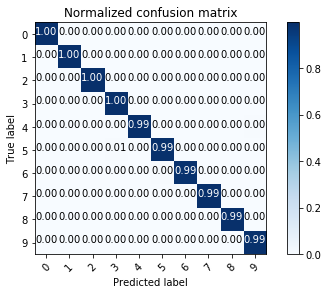

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

z_pred = model2.predict(x_test)
y_pred = np.argmax(z_pred,axis=1)

class_names= ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

To conclude, an overview of results obtained with different methodologies can be found here: https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.